#### StyleGAN은 Progressive GAN(PGGAN)을 baseline으로 발전된 형태이다.

- 기존의 훈련 mechanism은 거의 똑같고 generator의 구성만 바뀌었다.

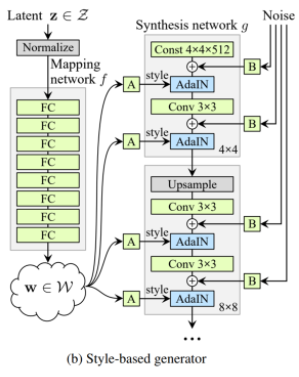

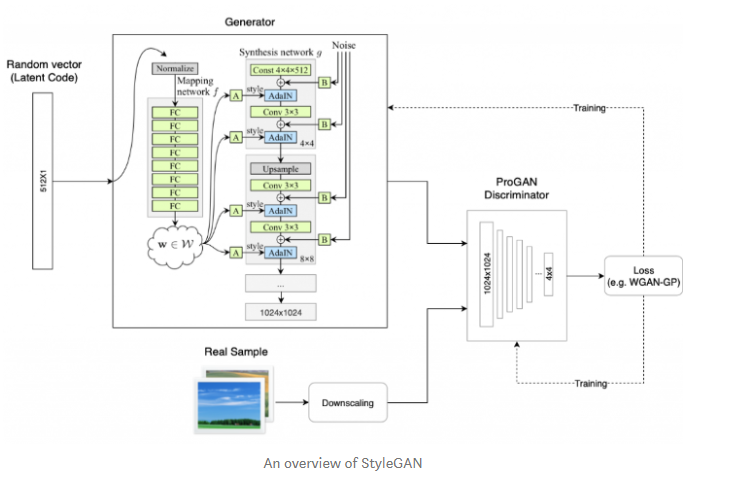

#### StyleGAN
- latent variabe z를 8개의 fc를 통해서 w로 변환시켜준다.
    - 이는 synthesis network에서 이미지를 입히는 style 정보를 의미한다.

- Synthesis Network는 latent variable로 부터 만들어온 style information w를 이용해 이미지를 생성(합성)해주는 네트워크이다.

#### trunction trick
- truncation trick은 학습을 잘 하기위한 trick이 아니다.
- 학습이 다 끝난 후미지를 생성할 때 더 좋은 퀄리티의 이미지를 뽑는 방법이다.
- 이는 모델이 얼마나 이미지를 잘 생성해냈는지에 대한 정보와 스타일의 강도를 조절한다.

#### synthesis

- AdaIN(x_i, y)연산에서 y를 곱하고 (바이어스를)더해 이미지를 생성해내는 것이다.

#### Style mixing

- Style mixing: 학습시 regularuzation 방법. 하나의 z를 이용하는 것이 아니라 두 개의 z를 이용하였다.
    - z1, z2를 이용해 w1과 w2를 구하고, w1으로 구해놓은 스타일을 입히고, random하게 w2로 구한 스타일을 추가로 입히겠다.
    
- coarse style 앞 부분은 w1
- 중간부분은 w2
- 마지막 부분은 w3
![nn](img/1.png)

#### stochasitc variation

- 이미지에 크게 영향을 미치는 부분(머리의 흩날림, 모공)은 latent variable로 조정이 가능하다.

- 그렇다면 이미지에 대해서 main정보(여자, 안경여부)등의 큰 정보말고, 미세한 정보(머리카라 휘날림, 주름)는 어떻게 조정해야할까?
    - 이를 위해 사용하는 것이 Noise를 Adain연산 전에 더해주는 것이다.
    - 효과를 localized 하는 것을 확인할 수 있었다. (특정 부분에만 영향을 미치는 것을 확인할 수 있었다는 말)
    
    
- style -> global effects(pose/identity)
- noise -> stochasitc variation

#### Englment

- z를 이용해 sample의 분포를 쫒아가면, 하나의 z로 특정한 부분만 바꾸기 어려운데, (Englement가 일어남)
- 이를 w를 이용해 sample의 분포를 쫒아가면서, z로 특정 부분을 조정하기 수월해졌다.

![nn](img/2.png)

#### 지표
- perceptual path length: z와 z+e(작은 값, epsilon) 을 이용해 만든 각각의 embedding된 feature값들의 변화를 지표로 삼겠다.
    - 많이 바뀌면 안좋겠지
    - 생성된 이미지의 얼굴 부분만 사용
    
    
    
- Linear separability: disentanglement 되었다면 주름을 만드는 factor의 direction을 구하고 싶다.

In [1]:
import pickle
import IPython
import numpy as np
import handcalcs.render

import torch
import torch.nn as nn
import torch.nn.functional as F

from math import sqrt
from collections import OrderedDict

#### MyLinear

- HE initialization을 사용하자는 것 같은데, 현재 버전은 파이토치가 기본으로 사용하고있음.
    - 일단 Linear 바닥 구현이니까 잘 해두자

- lrmul: learning rate multiplier // 매 layer마다 learing rate을 다르게 설정해주고 싶을 때 설정한다.

In [2]:
class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init
        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)   # input, weight

### Convolution Layer

- The Convolution layer도 위와 같은 식으로 변형한다.
- StyleGAN의 구조에서 upscaling과 blurring이 bias addition에서 지속적으로 일어남으로, mechanism을 바꿔줄 필요가 있다.

In [3]:
class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        
        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)
    
        if not have_convolution and self.intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)
        
        if self.intermediate is not None:
            x = self.intermediate(x)
        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

### Noise Layer

- 노이즈 레이어는 learnable standard deviation을 가우시안 노이즈를 만드는 레이어이다.

In [4]:
class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None
    
    def forward(self, x, noise=None):
        
        
        #print('x', x.size())
        
        
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            # here is a little trick: if you get all the noiselayers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

### Style Modification layer (AdaIN)

- 생성자 내부 구조중, style modification layer는 매 norm layer이후에 사용된다.
- instance norm은 각 채널에 대해서 pixels에 대해서 mean 과 std 정규화한다.
- Author는 affine Instance Norm Adaptive Instance Norm(AdaIN)이라 부른다.

In [5]:
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)
        
    def forward(self, x, latent):
        style = self.lin(latent) # style => [batch_size, n_channels*2]
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

### Pixelnorm

- [batch x 512]의 형태
- batch 마다 평균을 구하고 epsilon을 더해준 다음 sqrt의 역수 를 input값에 곱해준다

In [6]:
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

### Upscale and blur layers

- StyleGAN은 두 타입의 upscaling이 있다.
    1. plain one: 2배 만큼 크게 만들기 위해 한 픽셀을 2 * 2 block에 넣는 방법
    2. fused with convolution: stride 2의 transposed convolution을 사용한다.

- generator는 가장 간단한 smoothing kernel로 convolution 하면서 해당 layer를 blurring한다.

In [7]:
class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True,
                flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel = [1, 2, 1]
        kernel = torch.tensor(kernel, dtype = torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride
        
    def forward(self, x):
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel, stride=self.stride,
            padding = int((self.kernel.size(2)-1)/2),
            groups = x.size(1)
        )
        
        return x
    
def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        
        return upscale2d(x, factor=self.factor, gain=self.gain)

In [8]:
class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))
        
    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

In [9]:
class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):

        
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x


class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        
    def forward(self, dlatents_in_range):
        
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x


class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        # 2**res x 2**res # res = 3..resolution_log2
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
           
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
            
    def forward(self, x, dlatents_in_range):
        x = self.conv0_up(x)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

In [10]:
class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
        num_channels        = 3,            # Number of output color channels.
        resolution          = 1024,         # Output resolution.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        use_styles          = True,         # Enable style inputs?
        const_input_layer   = True,         # First layer is a learned constant?
        use_noise           = True,         # Enable noise inputs?
        randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
        use_wscale          = True,         # Enable equalized learning rate?
        use_pixel_norm      = False,        # Enable pixelwise feature vector normalization?
        use_instance_norm   = True,         # Enable instance normalization?
        dtype               = torch.float32,  # Data type to use for activations and outputs.
        blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
        ):
        
        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
                
            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels, num_channels, 1, gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))
        
    def forward(self, dlatents_in):
        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
        # lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0), trainable=False), dtype)
        batch_size = dlatents_in.size(0)       
        for i, m in enumerate(self.blocks.values()):
            if i == 0:
                x = m(dlatents_in[:, 2*i:2*i+2])
            else:
                x = m(x, dlatents_in[:, 2*i:2*i+2])
        rgb = self.torgb(x)
        return rgb

In [11]:
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    #('truncation', Truncation(avg_latent)),
    ('g_synthesis', G_synthesis())    
]))

In [12]:
g_all

Sequential(
  (g_mapping): G_mapping(
    (pixel_norm): PixelNormLayer()
    (dense0): MyLinear()
    (dense0_act): LeakyReLU(negative_slope=0.2)
    (dense1): MyLinear()
    (dense1_act): LeakyReLU(negative_slope=0.2)
    (dense2): MyLinear()
    (dense2_act): LeakyReLU(negative_slope=0.2)
    (dense3): MyLinear()
    (dense3_act): LeakyReLU(negative_slope=0.2)
    (dense4): MyLinear()
    (dense4_act): LeakyReLU(negative_slope=0.2)
    (dense5): MyLinear()
    (dense5_act): LeakyReLU(negative_slope=0.2)
    (dense6): MyLinear()
    (dense6_act): LeakyReLU(negative_slope=0.2)
    (dense7): MyLinear()
    (dense7_act): LeakyReLU(negative_slope=0.2)
  )
  (g_synthesis): G_synthesis(
    (torgb): MyConv2d()
    (blocks): ModuleDict(
      (4x4): InputBlock(
        (epi1): LayerEpilogue(
          (top_epi): Sequential(
            (noise): NoiseLayer()
            (activation): LeakyReLU(negative_slope=0.2)
            (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine

In [13]:
if 0:
    # this can be run to get the weights, but you need the reference implementation and weights
    import dnnlib, dnnlib.tflib, pickle, torch, collections
    dnnlib.tflib.init_tf()
    weights = pickle.load(open('./karras2019stylegan-ffhq-1024x1024.pkl','rb'))
    weights_pt = [collections.OrderedDict([(k, torch.from_numpy(v.value().eval())) for k,v in w.trainables.items()]) for w in weights]
    torch.save(weights_pt, './karras2019stylegan-ffhq-1024x1024.pt')
if 0:
    # then on the PyTorch side run
    state_G, state_D, state_Gs = torch.load('./karras2019stylegan-ffhq-1024x1024.pt')
    def key_translate(k):
        k = k.lower().split('/')
        if k[0] == 'g_synthesis':
            if not k[1].startswith('torgb'):
                k.insert(1, 'blocks')
            k = '.'.join(k)
            k = (k.replace('const.const','const').replace('const.bias','bias').replace('const.stylemod','epi1.style_mod.lin')
                  .replace('const.noise.weight','epi1.top_epi.noise.weight')
                  .replace('conv.noise.weight','epi2.top_epi.noise.weight')
                  .replace('conv.stylemod','epi2.style_mod.lin')
                  .replace('conv0_up.noise.weight', 'epi1.top_epi.noise.weight')
                  .replace('conv0_up.stylemod','epi1.style_mod.lin')
                  .replace('conv1.noise.weight', 'epi2.top_epi.noise.weight')
                  .replace('conv1.stylemod','epi2.style_mod.lin')
                  .replace('torgb_lod0','torgb'))
        else:
            k = '.'.join(k)
        return k

    def weight_translate(k, w):
        k = key_translate(k)
        if k.endswith('.weight'):
            if w.dim() == 2:
                w = w.t()
            elif w.dim() == 1:
                pass
            else:
                assert w.dim() == 4
                w = w.permute(3, 2, 0, 1)
        return w

    # we delete the useless torgb filters
    param_dict = {key_translate(k) : weight_translate(k, v) for k,v in state_Gs.items() if 'torgb_lod' not in key_translate(k)}
    if 1:
        sd_shapes = {k : v.shape for k,v in g_all.state_dict().items()}
        param_shapes = {k : v.shape for k,v in param_dict.items() }

        for k in list(sd_shapes)+list(param_shapes):
            pds = param_shapes.get(k)
            sds = sd_shapes.get(k)
            if pds is None:
                print ("sd only", k, sds)
            elif sds is None:
                print ("pd only", k, pds)
            elif sds != pds:
                print ("mismatch!", k, pds, sds)

    g_all.load_state_dict(param_dict, strict=False) # needed for the blur kernels
    torch.save(g_all.state_dict(), './karras2019stylegan-ffhq-1024x1024.for_g_all.pt')

In [14]:
g_all.load_state_dict(torch.load('./karras2019stylegan-ffhq-1024x1024.for_g_all.pt'))

<All keys matched successfully>

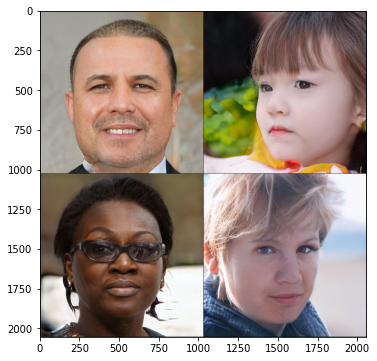

In [15]:
%matplotlib inline
from matplotlib import pyplot
import torchvision
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all.eval()
g_all.to(device)

torch.manual_seed(20)
nb_rows = 2
nb_cols = 2
nb_samples = nb_rows * nb_cols
torch.manual_seed(999)
latents = torch.randn(nb_samples, 512, device=device)
with torch.no_grad():
    imgs = g_all(latents)
    imgs = (imgs.clamp(-1, 1) + 1) / 2.0 # normalization to 0..1 range
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

pyplot.figure(figsize=(15, 6))
pyplot.imshow(imgs.permute(1, 2, 0).detach().numpy())

#### Latents + 0.3

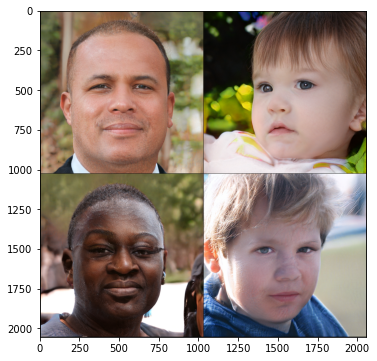

In [16]:
%matplotlib inline
from matplotlib import pyplot
import torchvision
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all.eval()
g_all.to(device)

torch.manual_seed(20)
nb_rows = 2
nb_cols = 2
nb_samples = nb_rows * nb_cols
torch.manual_seed(999)
latents = torch.randn(nb_samples, 512, device=device) + 0.3
with torch.no_grad():
    imgs = g_all(latents)
    imgs = (imgs.clamp(-1, 1) + 1) / 2.0 # normalization to 0..1 range
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

pyplot.figure(figsize=(15, 6))
pyplot.imshow(imgs.permute(1, 2, 0).detach().numpy())

#### Reference
- 메인 코드/설명: https://github.com/lernapparat/lernapparat/blob/master/style_gan/pytorch_style_gan.ipynb

- 추가 설명: https://jayhey.github.io/deep%20learning/2019/01/14/style_based_GAN_1/

- Nvidia: https://github.com/NVlabs/stylegan/blob/master/training/networks_stylegan.py